## Modules

In [1]:
# import basic modules
import pandas as pd
import warnings
import numpy as np
import os

In [2]:
# import all modules related to visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
# import all modules related to statistical computing
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import q_stat, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

In [4]:
# filter warnings
warnings.filterwarnings("ignore")

## Import Data

In [5]:
# import the training data and set index as date
training = pd.read_csv(os.getcwd() + "/Data/training.csv")
training["DATE"] = pd.to_datetime(training["DATE"])
training.set_index("DATE", inplace = True)

In [6]:
# import the validation data and set index as date
validation = pd.read_csv(os.getcwd() + "/Data/validation.csv")
validation["DATE"] = pd.to_datetime(validation["DATE"])
validation.set_index("DATE", inplace = True)

In [7]:
# import the testing data and set index as date
testing = pd.read_csv(os.getcwd() + "/Data/testing.csv")
testing["DATE"] = pd.to_datetime(testing["DATE"])
testing.set_index("DATE", inplace = True)

## Model Evaluation

In [8]:
# pseudo-out-of-sample (in-sample) forecast evaluation for arima models:
# 1. fit model parameters on the training sample and compute the aicc
# 2. produce one-step-ahead forecasts from the end of that sample
# 3. expand the sample to include the next observation, and repeat
# 4. compare forecasts against validation dataset to compute rmse
def evaluate_model(training, validation, order):
    history = [x for x in training.values]
    predictions = list()
    aicc_values = list()
    # iterate over each value in the validation set
    for t in range(len(validation.values)):
        # fit model on training sample
        model = ARIMA(history, order = order)
        model_fit = model.fit()
        aicc_values.append(model_fit.aicc)
        # compute one-step-ahead forecast
        y_hat = model_fit.forecast()[0]
        # append prediction to list
        predictions.append(y_hat)
        # expand the training sample to include next observation and repeat
        history.append(validation.values[t])
    # save original data and fitted values
    rmse = np.sqrt(mean_squared_error(validation, predictions))
    model_data = validation.copy()
    model_data["prediction"] = predictions
    # return the rmse and the fitted values for a given combination of (p,d,q)
    return np.asarray(aicc_values).mean(), rmse, model_data

**AR(p)-Model:** In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable.
$$ y_{t} = c + \alpha_{1}y_{t-1} + \alpha_{2}y_{t-2} + \cdots + \alpha_{p}y_{t-p} + \epsilon_{t} $$

**MA(q)-Model:** Rather than using past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model.
$$ y_{t} = c + \beta_{1}\epsilon_{t-1} + \beta_{2}\epsilon_{t-2} + \cdots + \beta_{q}\epsilon_{t-q} + \epsilon_{t} $$

**ARMA(p,q)-Model:** Autoregressive moving average models are simply a linear combination of AR(p) and MA(q) processes.
$$ y_{t} = c + \sum^{p}_{i=1}\alpha_{i}y_{t-i} + \sum^{q}_{j=1}\beta_{j}y_{t-j} + \epsilon_{t} $$

**ARIMA(p,d,q)-Model:** The ARIMA model is extending the ARMA model by including a term $d$ representing a finite differencing order and $\Delta^{d}y_{t}$ is the differenced series.
$$ \Delta^{d}y_{t} = c + \sum^{p}_{i=1}\alpha_{i}\Delta^{d}y_{t-i} + \sum^{q}_{j=1}\beta_{j}y_{t-j} + \epsilon_{t} $$

In [9]:
# grid-search function for finding the best combination of arima parameters (p,d,q)
def grid_search(training, validation, p_grid, d, q_grid):
    best_score, best_cfg = float("inf"), None
    aicc_values = list()
    for p in p_grid:
        for q in q_grid:
            order = (p,d,q)
            try:
                aicc, rmse, model_data = evaluate_model(training, validation, order)
                if aicc < best_score:
                    best_score, best_rmse, best_cfg, best_model_data = aicc, rmse, order, model_data
                print(">ARIMA%s -> AICc = %.3f" % (order, aicc))
                aicc_values.append(aicc)
            except:
                continue
    # print best model and return best configuration and best scores 
    print(">best model: ARIMA%s with AICc of %.3f" % (best_cfg, best_score))
    return best_cfg, best_model_data, aicc_values, best_rmse

In [43]:
# function for visualization of model training and the corresponding aicc
def plot_model(model_data, aicc, rmse):
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # plot actual and fitted values from model
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Actual")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP Growth")
    ax1.set_title("Fitted Values for best ARIMA Combination (RMSE = %.3f)" % (rmse), loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)

    ax2 = plt.subplot(gs[0, 1])
    # plot aicc values
    ax2.plot(aicc, color = "green")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("AICc Value")
    ax2.set_title("Corresponding AICc", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values on yearly average
    ax3.plot(model_data.iloc[:,0].resample("Y").mean(), color = "darkblue", 
             label = "Actual (yearly average)")
    ax3.plot(model_data.iloc[:,1].resample("Y").mean(), color = "red", 
             label = "Fitted (yearly average)", linestyle = "-")
    ax3.set_title("Yearly Average Fitted Values", loc = "left")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Real GDP Growth")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax3.legend(frameon = False, loc = "lower right")
    
    plt.tight_layout()

In [11]:
# select range of (p,d,q) parameters for grid-search
p, d, q = range(0,6), 0, range(0,6)

In [12]:
# run the grid-search
best_cfg, model_data, aicc_values, rmse = grid_search(training, validation, p, d, q)

>ARIMA(0, 0, 0) -> AICc = 679.818
>ARIMA(0, 0, 1) -> AICc = 659.023
>ARIMA(0, 0, 2) -> AICc = 647.979
>ARIMA(0, 0, 3) -> AICc = 648.702
>ARIMA(0, 0, 4) -> AICc = 650.781
>ARIMA(0, 0, 5) -> AICc = 647.810
>ARIMA(1, 0, 0) -> AICc = 650.827
>ARIMA(1, 0, 1) -> AICc = 651.440
>ARIMA(1, 0, 2) -> AICc = 649.028
>ARIMA(1, 0, 3) -> AICc = 649.302
>ARIMA(1, 0, 4) -> AICc = 649.481
>ARIMA(1, 0, 5) -> AICc = 649.428
>ARIMA(2, 0, 0) -> AICc = 650.206
>ARIMA(2, 0, 1) -> AICc = 649.993
>ARIMA(2, 0, 2) -> AICc = 647.698
>ARIMA(2, 0, 3) -> AICc = 646.280
>ARIMA(2, 0, 4) -> AICc = 647.216
>ARIMA(2, 0, 5) -> AICc = 648.654
>ARIMA(3, 0, 0) -> AICc = 648.073
>ARIMA(3, 0, 1) -> AICc = 647.779
>ARIMA(3, 0, 2) -> AICc = 649.452
>ARIMA(3, 0, 3) -> AICc = 650.164
>ARIMA(3, 0, 4) -> AICc = 647.826
>ARIMA(3, 0, 5) -> AICc = 651.017
>ARIMA(4, 0, 0) -> AICc = 648.590
>ARIMA(4, 0, 1) -> AICc = 649.801
>ARIMA(4, 0, 2) -> AICc = 649.782
>ARIMA(4, 0, 3) -> AICc = 646.589
>ARIMA(4, 0, 5) -> AICc = 649.784
>ARIMA(5, 0, 0

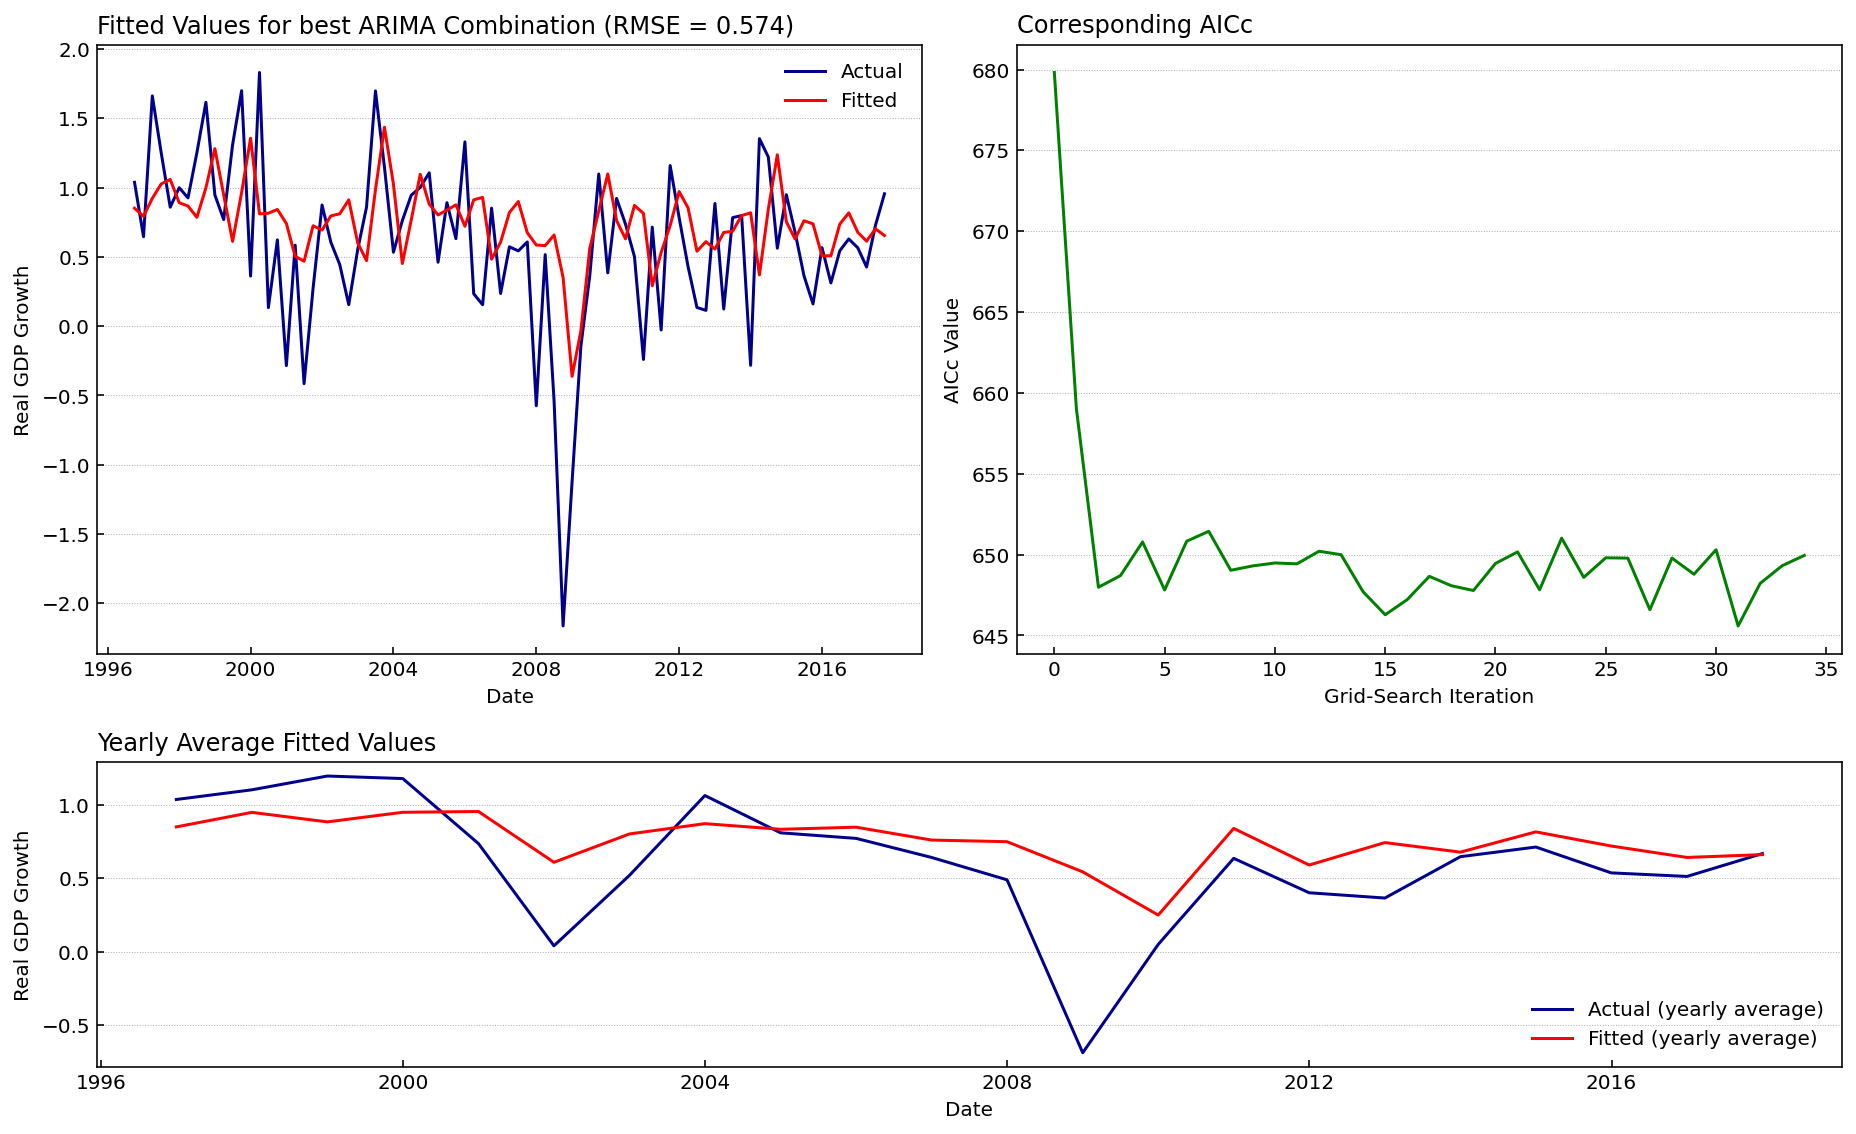

In [44]:
# plot the model training
plot_model(model_data, aicc_values, rmse)

## Residual Diagnostics

In [41]:
# function for visualization of the residuals for the chosen arima model
# good forecasting methods will yield innovation residuals with the following properties:
# 1. The residuals are uncorrelated (otherwise there is information left)
# 2. The residuals have zero mean (otherwise the forecasts are biased)
# 3. The residuals have constant variance (useful, but not necessary)
# 4. The residuals are normally distributed (useful, but not necessary)
def plot_residuals(data, order):
    # get residuals for the chosen combination of (p,d,q) parameters
    model = ARIMA(data, order = order)
    model_fit = model.fit()
    residuals = pd.DataFrame(model_fit.resid)
    
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # distribution plot
    residuals.plot(kind = "density", ax = ax1, color = "darkblue", legend = False)
    ax1.set_title("Density of Residuals", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # normal distribution
    mean, std = stats.norm.fit(residuals)
    x = np.linspace(-8, 8, 300)
    p = stats.norm.pdf(x, mean, std)
    ax1.plot(x, p, "green")
    ax1.legend(["Residuals", "Normal"], frameon = False)
    ax1.axvline(x = 0, color = "red", linestyle = "--")

    ax2 = plt.subplot(gs[0, 1])
    # compute the autocorrelation coefficients of the residuals and plot them
    plot_acf(residuals, ax = ax2, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_ylim(-0.25, 0.25)
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values on yearly average
    ax3.plot(residuals, color = "darkblue")
    ax3.axhline(y = 0, color = "red", linestyle = "--")
    ax3.set_title("Residuals", loc = "left")
    ax3.set_xlabel("Date")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    plt.tight_layout()
            
    # return the residual values
    return residuals

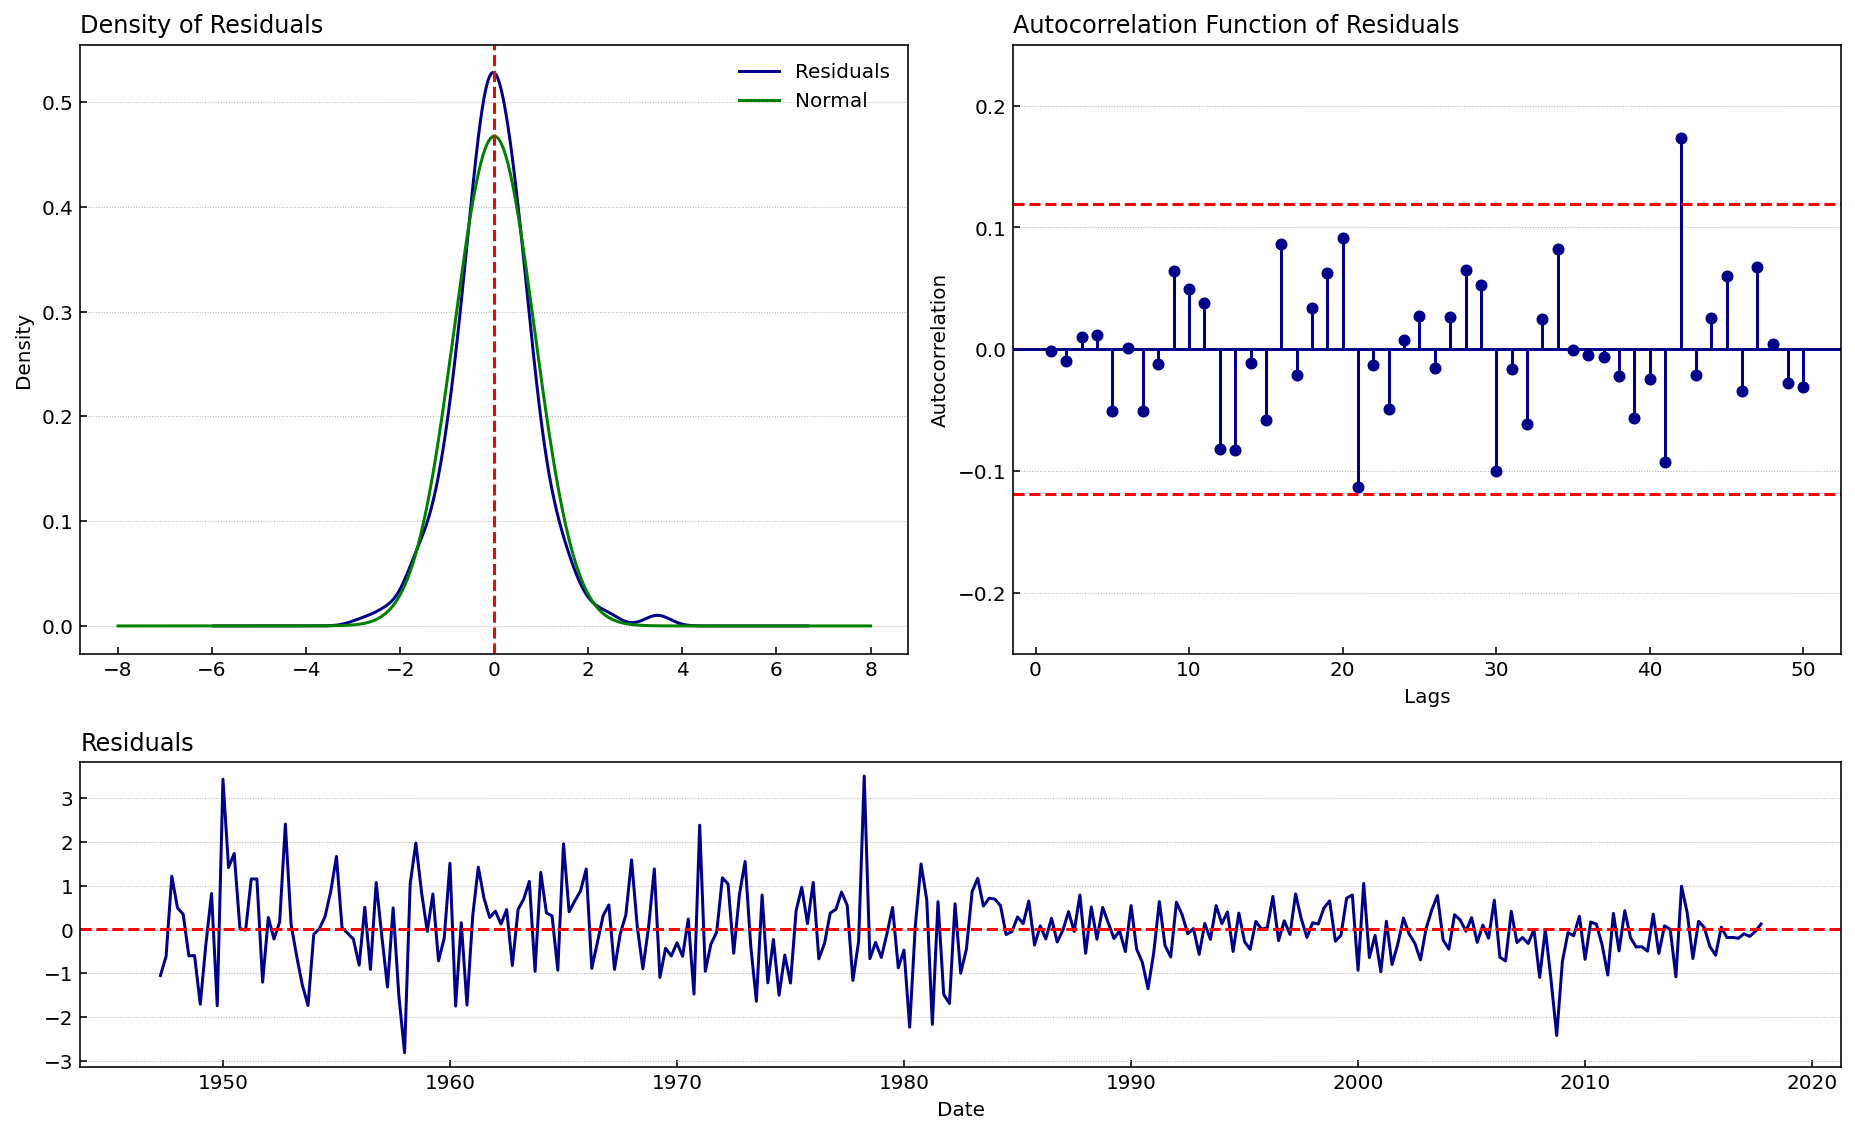

In [42]:
# residuals for chosen parameter combination on full training data
residuals = plot_residuals(pd.concat([training, validation]), best_cfg)

### Goldfeld-Quandt Test for Heteroskedasticity

In [16]:
###########################################################################################
# source code from statsmodels for heteroskedasticity test (Goldfeld-Quandt) of residuals #
###########################################################################################
def heteroskedasticity_test(resid, subset_length = 1/3):
    
    squared_resid = np.asarray(resid, dtype = float) ** 2
    if squared_resid.ndim == 1:
        squared_resid = squared_resid.reshape(-1, 1)
    nobs = len(resid)

    if 0 < subset_length < 1:
        h = int(np.round(nobs * subset_length))
    elif type(subset_length) is int and subset_length >= 1:
        h = subset_length

    numer_resid = squared_resid[-h:]
    numer_dof = (~np.isnan(numer_resid)).sum(axis = 0)
    numer_squared_sum = np.nansum(numer_resid, axis = 0)

    denom_resid = squared_resid[:h]
    denom_dof = (~np.isnan(denom_resid)).sum(axis = 0)
    denom_squared_sum = np.nansum(denom_resid, axis = 0)

    test_statistic = numer_squared_sum / denom_squared_sum

    from scipy.stats import f
    pval_lower = lambda test_statistics: f.cdf(test_statistics, numer_dof, denom_dof)
    pval_upper = lambda test_statistics: f.sf(test_statistics, numer_dof, denom_dof)
    p_value = 2 * np.minimum(pval_lower(test_statistic), pval_upper(test_statistic))

    if len(test_statistic) == 1:
        return test_statistic[0], p_value[0]

    return test_statistic, p_value

In [17]:
# Goldfeld-Quandt test
# null hypothesis : homoscedasticity of residuals (constant variance)
# alternate hypothesis : heteroscedasticity of residuals (variance not constant)
# reject null hypothesis if p-value <= 0.05
def gq_test(data):
    gq_test = heteroskedasticity_test(data)
    test_statistic, p_value = gq_test[0], gq_test[1]
    print("Goldfeld-Quandt test results")
    print("-> test statistic: " + str(round(test_statistic, 2)))
    print("-> p-value: "  + str(round(p_value, 2)))

$$ \text{Test Statistic:} \;\; F = \frac{S^2_{1}}{S^2_{2}} \;\; \text{with} \;\; S^2_{i} = \frac{1}{n_{i}-k}\sum^{n_{i}}_{j=1}\epsilon^2_{ij} $$

In [18]:
gq_test(residuals)

Goldfeld-Quandt test results
-> test statistic: 0.27
-> p-value: 0.0


### Ljung-Box-Q Test for Autocorrelation

In [19]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq_test = acorr_ljungbox(data)
    test_statistic, p_value = lbq_test[0].mean(), lbq_test[1].mean()
    print("Ljung-Box-Q test results")
    print("-> average test statistic: " + str(round(test_statistic, 2)))
    print("-> average p-value: "  + str(round(p_value, 2)))

$$ \text{Test Statistic:} \;\; Q = n(n+2)\sum^{h}_{k=1}\frac{r_{k}^2}{n-k} $$

In [20]:
lbq_test(residuals)

Ljung-Box-Q test results
-> average test statistic: 15.49
-> average p-value: 0.82


### Jarque-Bera Test for Normality

In [21]:
# Jarque-Bera test
# null hypothesis : data is normally distributed
# alternate hypothesis : data is not normally distributed
# reject null hypothesis if p-value <= 0.05
def jb_test(data):
    jb_test = jarque_bera(data)
    test_statistic, p_value, skew, kurtosis = jb_test[0].mean(), jb_test[1].mean(), jb_test[2].mean(), jb_test[3].mean()
    print("Jarque-Bera test results")
    print("-> test statistic: " + str(round(test_statistic, 2)))
    print("-> p-value: "  + str(round(p_value, 2)))
    print("-> estimated skew: "  + str(round(skew, 2)))
    print("-> estimated kurtosis: "  + str(round(kurtosis, 2)))

$$ \text{Test Statistic:} \;\; JB = \frac{N}{6}\left( v^2 + \frac{w^2}{4} \right) $$

In [22]:
jb_test(residuals)

Jarque-Bera test results
-> test statistic: 46.87
-> p-value: 0.0
-> estimated skew: 0.28
-> estimated kurtosis: 4.91


## Out-of-Sample Forecast on Test Data

In [23]:
# function for forecasting on test data with chosen arima model
def forecast(training, testing, order):
    model = ARIMA(training, order = order)
    model_fit = model.fit()
    y_hat = model_fit.forecast(steps = len(testing))
    rmse = np.sqrt(mean_squared_error(testing, y_hat))
    print("AICc = " + str(model_fit.aicc))
    print("RMSE = " + str(rmse))
    return y_hat

In [24]:
y_hat = forecast(pd.concat([training, validation]), testing, best_cfg)

AICc = 730.2654865351831
RMSE = 0.29188851708986685


In [25]:
# function for visualization of the forecast
def plot_forecast(training, testing, y_hat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    ax1.plot(training, color = "darkblue", label = "Training Data")
    ax1.plot(testing, color = "green", label = "Test Data")
    ax1.plot(y_hat, color = "red", label = "Forecasted Values")
    ax1.set_xlabel("Date")
    ax1.set_title("Forecast", loc = "left")
    ax1.legend(frameon = False)
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    ax2.plot(testing, color = "green")
    ax2.plot(y_hat, color = "red")
    ax2.set_xlabel("Date")
    ax2.set_title("Forecast (zoomed-in)", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

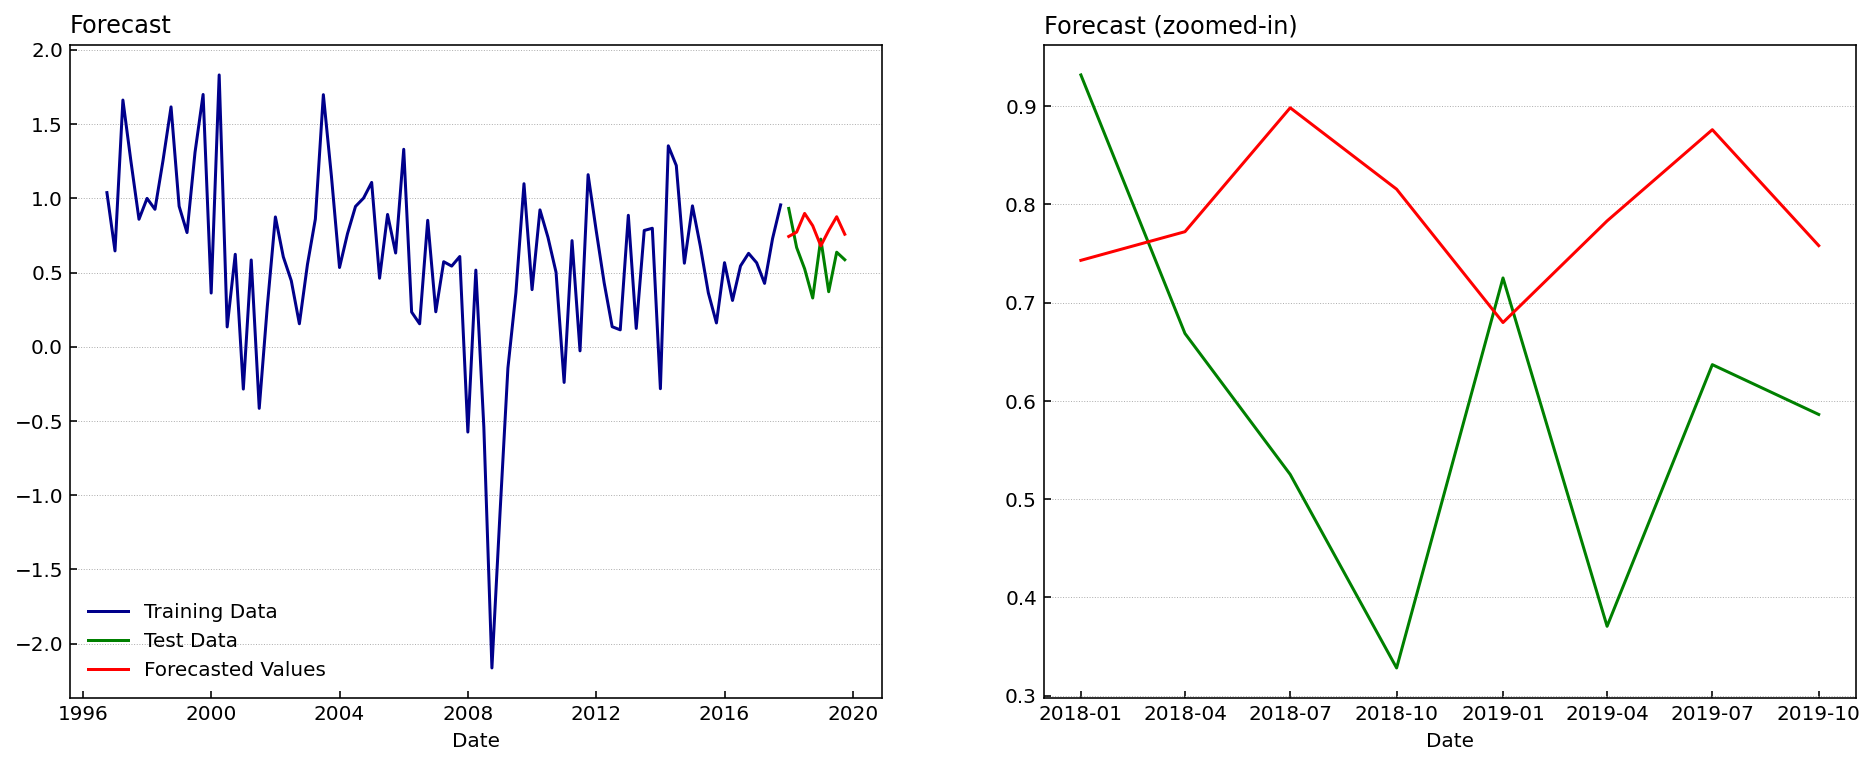

In [26]:
plot_forecast(validation, testing, y_hat)